In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

In [2]:
# If the dataframes have any missing values on the 'Tratamiento' column, delete those rows
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]):
    if df['Tratamiento'].isnull().any():
        df.dropna(subset=['Tratamiento'], inplace=True)
        print(f"Dropped missing 'Tratamiento' rows in df{i}")

Dropped missing 'Tratamiento' rows in df4
Dropped missing 'Tratamiento' rows in df10


In [3]:
# Remove 'Fus_EH' rows from each dataframe
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]):
    initial_count = len(df)
    df.drop(df[df['Tratamiento'] == 'Fus_EH'].index, inplace=True)

In [4]:
# Lets add the column 'Sana' to all dataframes except df0
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    df.insert(1, 'Sana', df['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))
    df.drop(columns=['Tratamiento'], inplace=True)
    # Now if the dataframe have the column 'Planta' delete it
    if 'Planta' in df.columns:
        df.drop(columns=['Planta'], inplace=True)


# lets take 2 samples of each dataframe to use as test data later and put them in the same csv file 
test_samples = []
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    test_sample = df.sample(n=31, random_state=42)
    test_sample.insert(0, 'Day', i)  # Add a column to identify from which sheet they come from
    test_samples.append(test_sample)

# concatenate all test samples into a single dataframe
test_data = pd.concat(test_samples, ignore_index=True)

# now remove the sampled rows from the original dataframes taking care to remove the 'Day' column first
for i, (df, test_sample) in enumerate(zip([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], 
                                            test_samples), start=0):
    df_sample = test_sample.drop(columns=['Day'])
    df.drop(df_sample.index, inplace=True)
    

<>:66: SyntaxWarning: invalid escape sequence '\&'
<>:66: SyntaxWarning: invalid escape sequence '\&'
C:\Users\ricar\AppData\Local\Temp\ipykernel_12164\1518793750.py:66: SyntaxWarning: invalid escape sequence '\&'
  fig.suptitle('2D Fourier Transform - Uniform Sampling (Healthy \& Unhealthy)', fontsize=16)


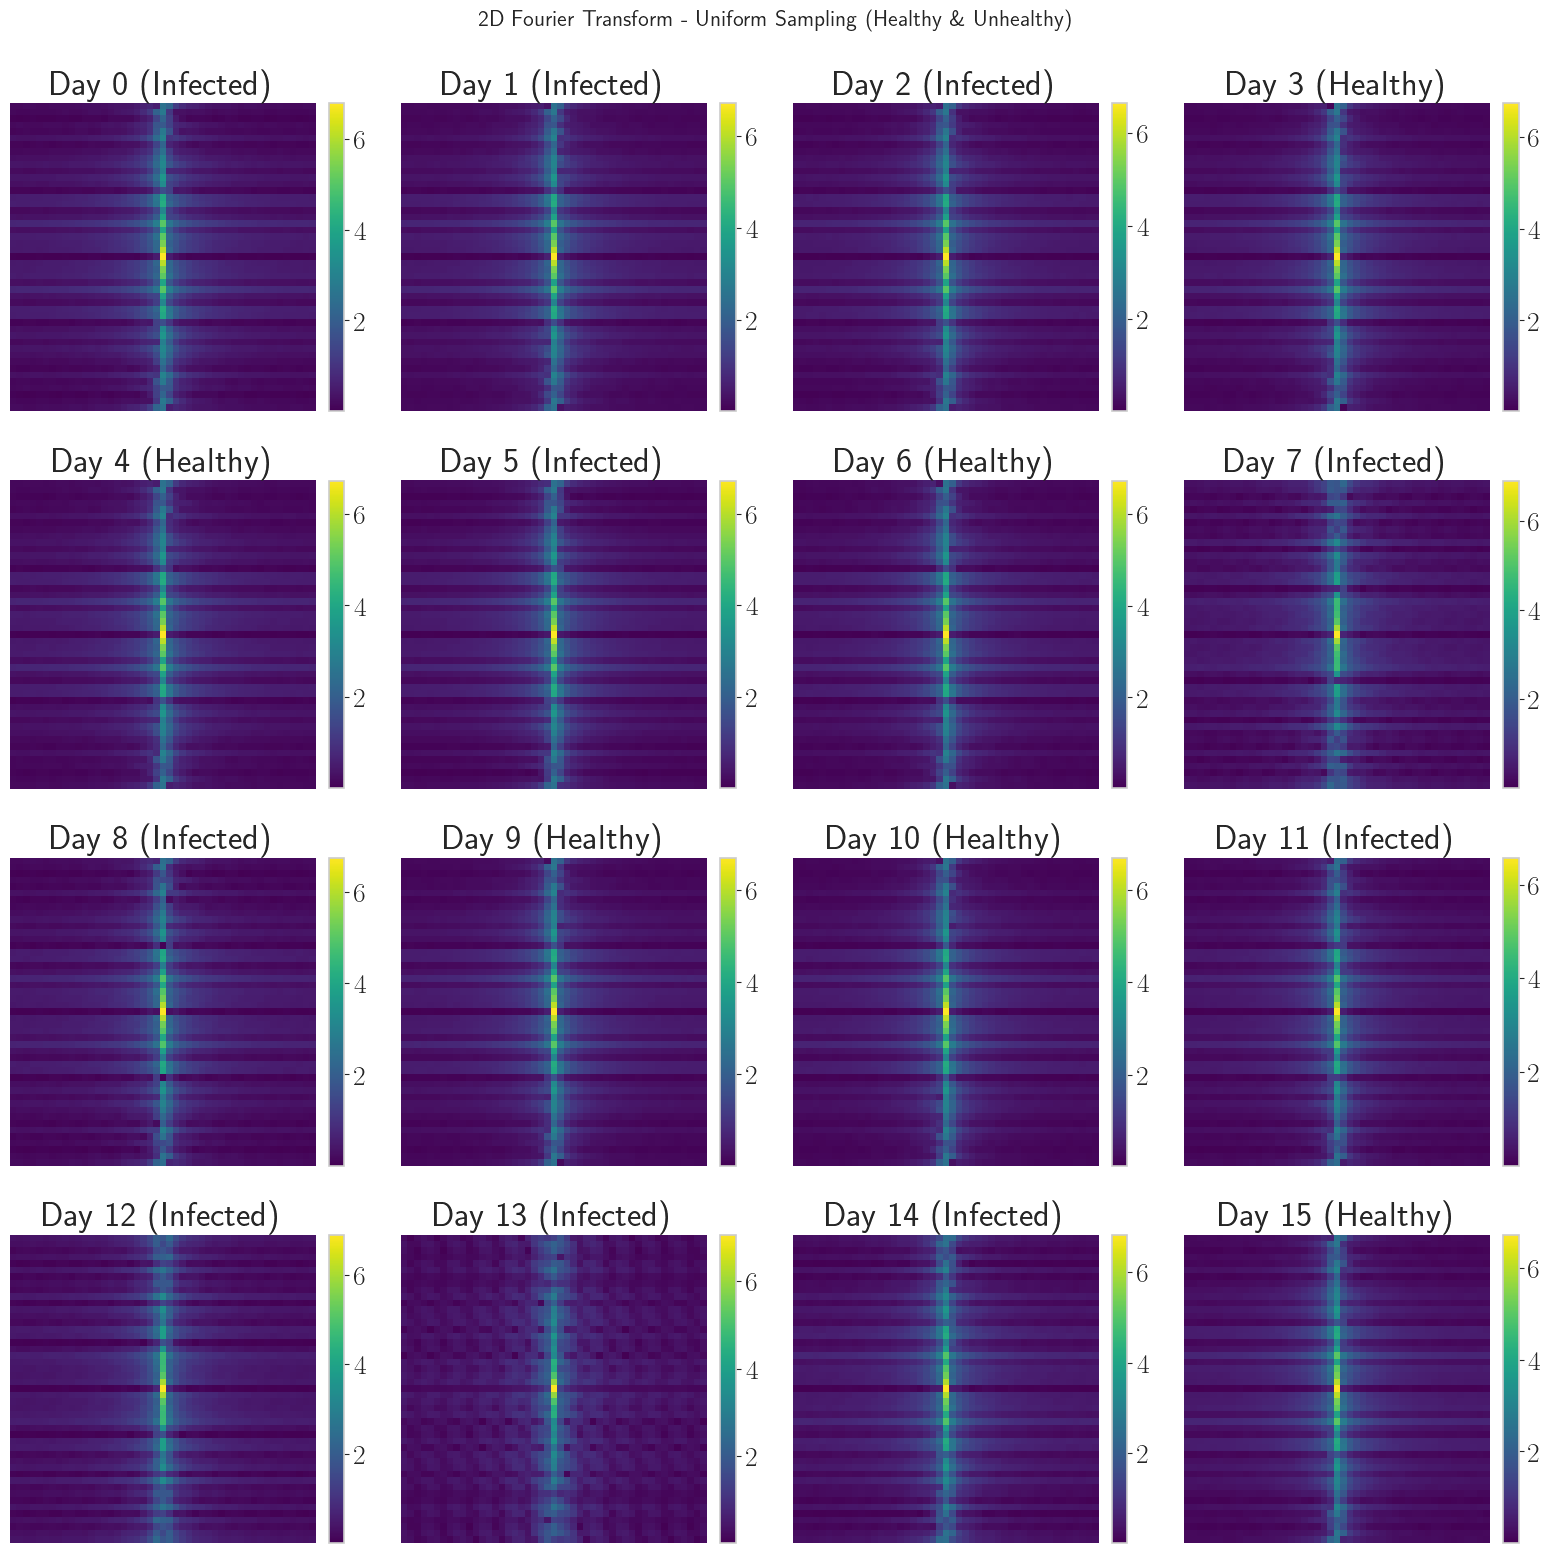

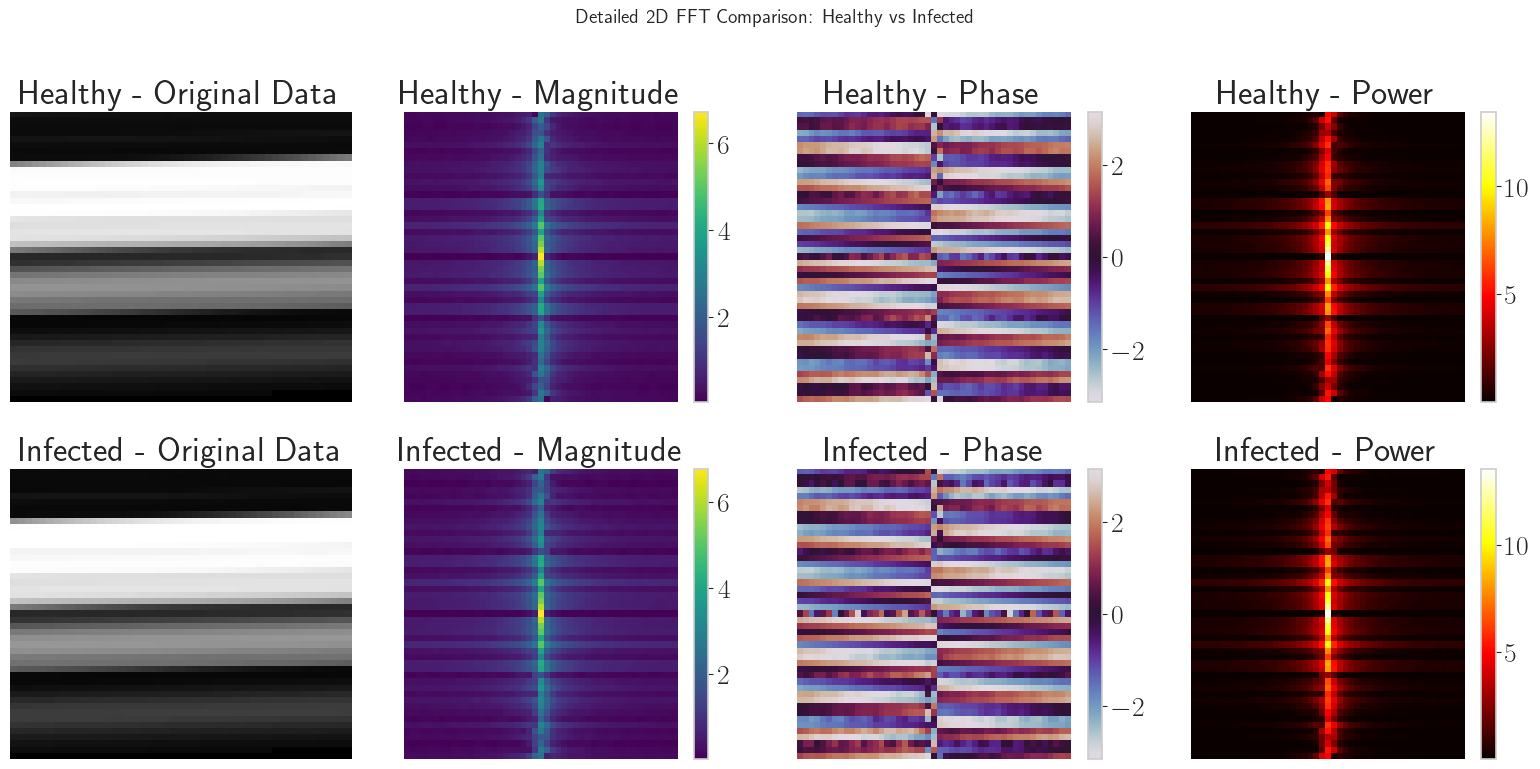

2D Fourier Transform Summary:
Total samples processed: 16
Healthy samples: 6
Infected samples: 10
Days represented: 16


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

# Select samples uniformly random between healthy (1) and unhealthy (0)
selected_samples = []
np.random.seed(42)  # Set seed for reproducibility

for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    # Separate healthy and unhealthy samples
    healthy_samples = df[df['Sana'] == 1]
    unhealthy_samples = df[df['Sana'] == 0]
    
    # Randomly choose which class to sample from (uniform random: 0 or 1)
    if len(healthy_samples) > 0 and len(unhealthy_samples) > 0:
        # Both classes available - randomly pick one with 50/50 probability
        label = np.random.choice([0, 1])
        if label == 1:
            sample = healthy_samples.sample(n=1).iloc[0]
        else:
            sample = unhealthy_samples.sample(n=1).iloc[0]
    elif len(healthy_samples) > 0:
        # Only healthy available
        sample = healthy_samples.sample(n=1).iloc[0]
        label = 1
    elif len(unhealthy_samples) > 0:
        # Only unhealthy available
        sample = unhealthy_samples.sample(n=1).iloc[0]
        label = 0
    else:
        continue  # Skip if no samples available
    
    # Extract spectral data (exclude 'Sana' column)
    selected_samples.append({
        'day': i,
        'data': sample.drop('Sana').values.flatten(),  # Flatten to ensure 1D array
        'label': label
    })

# Function to perform 2D Fourier Transform
def spatial_2d_fourier(data_1d, grid_size='auto'):
    if grid_size == 'auto':
        # Create square grid
        size = int(np.ceil(np.sqrt(len(data_1d))))
        grid_size = (size, size)
    
    # Reshape data to 2D (pad with zeros if necessary)
    data_2d = np.zeros(grid_size)
    data_2d.flat[:len(data_1d)] = data_1d
    
    # Apply 2D FFT and shift zero frequency to center
    fft_result = fft2(data_2d)
    fft_shifted = fftshift(fft_result)
    
    # Calculate magnitude and phase
    magnitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)
    
    return data_2d, magnitude, phase

# Apply 2D Fourier Transform and plot results
num_samples = len(selected_samples)
cols = 4
rows = int(np.ceil(num_samples / cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
fig.suptitle('2D Fourier Transform - Uniform Sampling (Healthy \& Unhealthy)', fontsize=16)
axes = axes.flatten()

for idx, sample_info in enumerate(selected_samples):
    ax = axes[idx]
    
    # Perform 2D Fourier Transform
    original_2d, magnitude, phase = spatial_2d_fourier(sample_info['data'])
    
    # Plot magnitude spectrum (log scale for better visualization)
    im = ax.imshow(np.log1p(magnitude), cmap='viridis', aspect='auto')
    ax.set_title(f"Day {sample_info['day']} ({'Healthy' if sample_info['label'] == 1 else 'Infected'})")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide unused subplots
for idx in range(num_samples, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot a detailed view for one healthy and one unhealthy sample
healthy_sample = next((s for s in selected_samples if s['label'] == 1), None)
unhealthy_sample = next((s for s in selected_samples if s['label'] == 0), None)

if healthy_sample and unhealthy_sample:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Detailed 2D FFT Comparison: Healthy vs Infected', fontsize=14)
    
    for row, (sample, label) in enumerate([(healthy_sample, 'Healthy'), (unhealthy_sample, 'Infected')]):
        original_2d, magnitude, phase = spatial_2d_fourier(sample['data'])
        power = magnitude ** 2
        
        # Original reshaped data
        axes[row, 0].imshow(original_2d, cmap='gray', aspect='auto')
        axes[row, 0].set_title(f'{label} - Original Data')
        axes[row, 0].axis('off')
        
        # Magnitude spectrum
        im1 = axes[row, 1].imshow(np.log1p(magnitude), cmap='viridis', aspect='auto')
        axes[row, 1].set_title(f'{label} - Magnitude')
        axes[row, 1].axis('off')
        plt.colorbar(im1, ax=axes[row, 1])
        
        # Phase spectrum
        im2 = axes[row, 2].imshow(phase, cmap='twilight', aspect='auto')
        axes[row, 2].set_title(f'{label} - Phase')
        axes[row, 2].axis('off')
        plt.colorbar(im2, ax=axes[row, 2])
        
        # Power spectrum
        im3 = axes[row, 3].imshow(np.log1p(power), cmap='hot', aspect='auto')
        axes[row, 3].set_title(f'{label} - Power')
        axes[row, 3].axis('off')
        plt.colorbar(im3, ax=axes[row, 3])
    
    plt.tight_layout()
    plt.show()

# Summary statistics
print("2D Fourier Transform Summary:")
print(f"Total samples processed: {len(selected_samples)}")
print(f"Healthy samples: {sum(1 for s in selected_samples if s['label'] == 1)}")
print(f"Infected samples: {sum(1 for s in selected_samples if s['label'] == 0)}")
print(f"Days represented: {len(set(s['day'] for s in selected_samples))}")